## Import module

In [1]:
#basic module
import pandas as pd # data processing
import numpy as np # linear algebra
import seaborn as sns
from matplotlib import pyplot as plt
import os
import time
import copy

#data preprocessing
from imblearn.combine import SMOTETomek
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV,cross_validate
from datasist.structdata import detect_outliers

# modeling
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

#Importing Library

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import lightgbm as lgb

# metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, classification_report, roc_auc_score, roc_curve

start = time.time()

In [2]:
# set GPU
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
    print("running on the GPU")
else:
    device = torch.device("cpu")
    print("running on the CPU")

running on the GPU


In [3]:
os.environ['CUDA_LAUNCH_BLOCKING']= "-1"

#### reference
- Heart Disease Prediction : https://www.kaggle.com/code/omarmohamedyehia/heart-disease-prediction

## Data Check

In [103]:
data = pd.read_csv("heart_2020_cleaned.csv",parse_dates=True, dayfirst=False)

In [6]:
outliers_indices = detect_outliers(data, 0, ['BMI'])
len(outliers_indices)

10396

In [7]:
data.drop(index = outliers_indices, inplace=True)

In [8]:
data

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319789,No,22.22,No,No,No,0.0,0.0,No,Female,18-24,Hispanic,No,Yes,Excellent,8.0,No,No,No
319790,Yes,27.41,Yes,No,No,7.0,0.0,Yes,Male,60-64,Hispanic,Yes,No,Fair,6.0,Yes,No,No
319791,No,29.84,Yes,No,No,0.0,0.0,No,Male,35-39,Hispanic,No,Yes,Very good,5.0,Yes,No,No
319792,No,24.24,No,No,No,0.0,0.0,No,Female,45-49,Hispanic,No,Yes,Good,6.0,No,No,No


In [8]:
for feature in data.columns: # feature 별 특징 확인
    print(feature)
    print(data[feature].unique(),"\n")

HeartDisease
['No' 'Yes'] 

BMI
[16.6  20.34 26.58 ... 41.23 15.57 40.7 ] 

Smoking
['Yes' 'No'] 

AlcoholDrinking
['No' 'Yes'] 

Stroke
['No' 'Yes'] 

PhysicalHealth
[ 3.  0. 20. 28.  6. 15.  5. 30.  7.  1.  2. 21.  4. 10. 14. 18.  8. 25.
 16. 29. 27. 17. 24. 12. 23. 26. 22. 19.  9. 13. 11.] 

MentalHealth
[30.  0.  2.  5. 15.  8.  4.  3. 10. 14. 20.  1.  7. 24. 28. 16. 12.  6.
 25. 17.  9. 18. 21. 29. 22. 13. 23. 27. 26. 11. 19.] 

DiffWalking
['No' 'Yes'] 

Sex
['Female' 'Male'] 

AgeCategory
['55-59' '80 or older' '65-69' '75-79' '40-44' '70-74' '60-64' '50-54'
 '45-49' '18-24' '35-39' '30-34' '25-29'] 

Race
['White' 'Black' 'Asian' 'American Indian/Alaskan Native' 'Other'
 'Hispanic'] 

Diabetic
['Yes' 'No' 'No, borderline diabetes' 'Yes (during pregnancy)'] 

PhysicalActivity
['Yes' 'No'] 

GenHealth
['Very good' 'Fair' 'Good' 'Poor' 'Excellent'] 

SleepTime
[ 5.  7.  8.  6. 12.  4.  9. 10. 15.  3.  2.  1. 18. 14. 16. 20. 11. 13.
 17. 24. 19. 21. 22. 23.] 

Asthma
['Yes' 'No'] 


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 309399 entries, 0 to 319793
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      309399 non-null  object 
 1   BMI               309399 non-null  float64
 2   Smoking           309399 non-null  object 
 3   AlcoholDrinking   309399 non-null  object 
 4   Stroke            309399 non-null  object 
 5   PhysicalHealth    309399 non-null  float64
 6   MentalHealth      309399 non-null  float64
 7   DiffWalking       309399 non-null  object 
 8   Sex               309399 non-null  object 
 9   AgeCategory       309399 non-null  object 
 10  Race              309399 non-null  object 
 11  Diabetic          309399 non-null  object 
 12  PhysicalActivity  309399 non-null  object 
 13  GenHealth         309399 non-null  object 
 14  SleepTime         309399 non-null  float64
 15  Asthma            309399 non-null  object 
 16  KidneyDisease     30

In [10]:
No_Value = data.HeartDisease.value_counts()[0]
Yes_Value = data.HeartDisease.value_counts()[1]
print("The number of Yes Value has {}%".format(((Yes_Value/len(data))*100).round(2)))

The number of Yes Value has 8.46%


## Data Preprocessing

### Ordinal Encoder

In [11]:
mapping_Genhealth={'Poor': 0, 'Fair': 1, 'Good': 2, 'Very good': 3, 'Excellent': 4}
mapping_AgeCategory ={'18-24': 0, '25-29': 1, '30-34': 2, '35-39': 3, '40-44': 4, '45-49': 5, '50-54': 6,
 '55-59': 7, '60-64': 8, '65-69': 9, '70-74': 10, '75-79': 11, '80 or older': 12}
mapping_yes_no={'Yes':1,'No':0}
Yes_No_Columns=['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'PhysicalActivity', 'Asthma',
                'KidneyDisease', 'SkinCancer']

In [12]:
data[Yes_No_Columns]=data[Yes_No_Columns].replace(mapping_yes_no)
data['GenHealth']=data['GenHealth'].map(mapping_Genhealth)
data['AgeCategory']=data['AgeCategory'].map(mapping_AgeCategory)
data['HeartDisease']=data['HeartDisease'].map(mapping_yes_no)

In [13]:
data_enc = data.copy()

In [14]:
for feature in data_enc.columns:
    print(feature)
    print(data_enc[feature].unique(),"\n")

HeartDisease
[0 1] 

BMI
[16.6  20.34 26.58 ... 41.23 15.57 40.7 ] 

Smoking
[1 0] 

AlcoholDrinking
[0 1] 

Stroke
[0 1] 

PhysicalHealth
[ 3.  0. 20. 28.  6. 15.  5. 30.  7.  1.  2. 21.  4. 10. 14. 18.  8. 25.
 16. 29. 27. 17. 24. 12. 23. 26. 22. 19.  9. 13. 11.] 

MentalHealth
[30.  0.  2.  5. 15.  8.  4.  3. 10. 14. 20.  1.  7. 24. 28. 16. 12.  6.
 25. 17.  9. 18. 21. 29. 22. 13. 23. 27. 26. 11. 19.] 

DiffWalking
[0 1] 

Sex
['Female' 'Male'] 

AgeCategory
[ 7 12  9 11  4 10  8  6  5  0  3  2  1] 

Race
['White' 'Black' 'Asian' 'American Indian/Alaskan Native' 'Other'
 'Hispanic'] 

Diabetic
['Yes' 'No' 'No, borderline diabetes' 'Yes (during pregnancy)'] 

PhysicalActivity
[1 0] 

GenHealth
[3 1 2 0 4] 

SleepTime
[ 5.  7.  8.  6. 12.  4.  9. 10. 15.  3.  2.  1. 18. 14. 16. 20. 11. 13.
 17. 24. 19. 21. 22. 23.] 

Asthma
[1 0] 

KidneyDisease
[0 1] 

SkinCancer
[1 0] 



### One-Hot Encoding

In [15]:
one_cols =['Sex','Race', 'Diabetic']
data_enc=pd.get_dummies(data_enc,columns=one_cols,drop_first=True).copy()

In [16]:
data_enc

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,AgeCategory,PhysicalActivity,...,SkinCancer,Sex_Male,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White,"Diabetic_No, borderline diabetes",Diabetic_Yes,Diabetic_Yes (during pregnancy)
0,0,16.60,1,0,0,3.0,30.0,0,7,1,...,1,0,0,0,0,0,1,0,1,0
1,0,20.34,0,0,1,0.0,0.0,0,12,1,...,0,0,0,0,0,0,1,0,0,0
2,0,26.58,1,0,0,20.0,30.0,0,9,1,...,0,1,0,0,0,0,1,0,1,0
3,0,24.21,0,0,0,0.0,0.0,0,11,0,...,1,0,0,0,0,0,1,0,0,0
4,0,23.71,0,0,0,28.0,0.0,1,4,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319789,0,22.22,0,0,0,0.0,0.0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
319790,1,27.41,1,0,0,7.0,0.0,1,8,0,...,0,1,0,0,1,0,0,0,1,0
319791,0,29.84,1,0,0,0.0,0.0,0,3,1,...,0,1,0,0,1,0,0,0,0,0
319792,0,24.24,0,0,0,0.0,0.0,0,5,1,...,0,0,0,0,1,0,0,0,0,0


### Data Split

In [17]:
features = data_enc.drop(columns =['HeartDisease'], axis = 1)
target = data_enc['HeartDisease']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(features, target, shuffle = True, test_size = .2, random_state = 44)
X_train_LBGM, X_val_LBGM, y_train_LBGM, y_val_LBGM = train_test_split(X_train, y_train, shuffle = True, test_size = 0.125, random_state = 44)

In [19]:
# standardization 적용 부분
enc_col = ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']
X_train_std=X_train[enc_col].copy()
X_test_std=X_test[enc_col].copy()
X_train_LBGM_std=X_train_LBGM[enc_col].copy()
X_val_LBGM_std=X_val_LBGM[enc_col].copy()

# one hot 된 부분
com_col = ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'AgeCategory', 'PhysicalActivity',
       'GenHealth', 'Asthma', 'KidneyDisease', 'SkinCancer',
       'Sex_Male', 'Race_Asian', 'Race_Black', 'Race_Hispanic', 'Race_Other',
       'Race_White', 'Diabetic_No, borderline diabetes', 'Diabetic_Yes',
       'Diabetic_Yes (during pregnancy)']
X_train_com=X_train[com_col].copy()
X_test_com=X_test[com_col].copy()
X_train_LBGM_com=X_train_LBGM[com_col].copy()
X_val_LBGM_com=X_val_LBGM[com_col].copy()

In [20]:
X_train_com

,Smoking,AlcoholDrinking,Stroke,DiffWalking,AgeCategory,PhysicalActivity,GenHealth,Asthma,KidneyDisease,SkinCancer,Sex_Male,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White,"Diabetic_No, borderline diabetes",Diabetic_Yes,Diabetic_Yes (during pregnancy)
121347,0,0,0,0,9,1,2,0,0,0,1,0,0,0,0,1,0,0,0
176896,1,0,0,0,8,1,4,0,0,0,0,0,0,0,0,1,0,0,0
235725,1,0,0,1,12,0,1,0,0,0,1,0,0,0,0,1,0,0,0
211643,0,0,0,0,1,1,4,0,0,0,0,0,0,0,0,1,0,0,0
218810,1,0,0,1,9,0,0,1,0,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51134,1,1,0,0,5,1,3,0,0,0,0,0,0,0,0,1,0,0,0
162150,1,0,0,0,6,1,3,1,0,0,1,0,0,0,0,1,0,0,0
265439,0,0,0,0,4,1,2,0,0,0,0,0,0,0,0,1,0,0,0
206621,0,0,0,0,12,1,2,0,0,0,1,0,0,0,0,1,0,0,0


In [21]:
X_train_com = X_train_com.reset_index(drop=True)
X_test_com = X_test_com.reset_index(drop=True)
X_train_LBGM_com = X_train_LBGM_com.reset_index(drop=True)
X_val_LBGM_com = X_val_LBGM_com.reset_index(drop=True)

y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
y_train_LBGM = y_train_LBGM.reset_index(drop=True)
y_val_LBGM = y_val_LBGM.reset_index(drop=True)

### Standard Scaler

In [22]:
stand_scale = StandardScaler()
stand_scale.fit(X_train_std)

StandardScaler()

In [23]:
X_train_std = stand_scale.transform(X_train_std)
X_test_std = stand_scale.transform(X_test_std)
X_train_LBGM_std= stand_scale.transform(X_train_LBGM_std)
X_val_LBGM_std= stand_scale.transform(X_val_LBGM_std)

In [24]:
X_train_std = pd.DataFrame(X_train_std , columns = enc_col)
X_test_std = pd.DataFrame(X_test_std  , columns = enc_col)
X_train_LBGM_std = pd.DataFrame(X_train_LBGM_std , columns = enc_col)
X_val_LBGM_std = pd.DataFrame(X_val_LBGM_std  , columns = enc_col)

In [25]:
X_train_LBGM_com

,Smoking,AlcoholDrinking,Stroke,DiffWalking,AgeCategory,PhysicalActivity,GenHealth,Asthma,KidneyDisease,SkinCancer,Sex_Male,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White,"Diabetic_No, borderline diabetes",Diabetic_Yes,Diabetic_Yes (during pregnancy)
0,0,0,0,0,11,1,1,0,0,0,1,1,0,0,0,0,0,0,0
1,0,0,0,0,3,0,3,0,0,0,1,0,0,0,0,1,0,0,0
2,1,0,1,0,12,1,3,0,0,0,1,0,0,0,0,1,0,0,0
3,0,0,0,0,10,1,4,0,0,0,0,0,0,0,0,1,0,0,0
4,1,0,0,0,2,1,4,0,0,0,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216574,0,0,1,1,10,1,0,0,0,0,0,0,0,0,0,1,0,1,0
216575,0,0,0,0,9,1,2,0,0,1,1,0,0,0,0,1,0,0,0
216576,0,0,0,0,7,1,1,0,0,0,1,0,1,0,0,0,0,0,0
216577,1,0,0,0,10,1,3,0,0,0,1,0,0,0,1,0,0,0,0


In [26]:
X_train = pd.merge(X_train_std, X_train_com,left_index=True, right_index=True)
X_test = pd.merge(X_test_std, X_test_com,left_index=True, right_index=True)
X_train_LBGM = pd.merge(X_train_LBGM_std, X_train_LBGM_com,left_index=True, right_index=True)
X_val_LBGM = pd.merge(X_val_LBGM_std, X_val_LBGM_com,left_index=True, right_index=True)

In [27]:
X_val_LBGM

,BMI,PhysicalHealth,MentalHealth,SleepTime,Smoking,AlcoholDrinking,Stroke,DiffWalking,AgeCategory,PhysicalActivity,...,SkinCancer,Sex_Male,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White,"Diabetic_No, borderline diabetes",Diabetic_Yes,Diabetic_Yes (during pregnancy)
0,0.818075,-0.414907,-0.483757,-0.072352,0,0,0,0,6,1,...,0,0,0,0,1,0,0,0,0,0
1,-0.493128,-0.414907,-0.483757,-0.072352,0,0,0,0,10,1,...,1,1,0,0,0,0,1,0,0,0
2,-0.360664,0.226777,0.153961,0.630387,1,0,0,0,12,1,...,0,0,0,0,0,0,1,0,0,0
3,-1.180406,-0.414907,-0.483757,-0.775092,1,0,0,0,12,1,...,1,1,0,0,0,0,1,0,0,0
4,-0.491209,-0.286570,-0.483757,-0.072352,0,0,0,0,10,1,...,1,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30935,-0.105335,-0.414907,-0.483757,-0.072352,0,0,0,0,1,1,...,0,1,0,0,1,0,0,0,0,0
30936,-0.289633,-0.414907,2.704832,-0.775092,1,0,0,0,6,1,...,0,0,0,0,0,0,1,0,0,0
30937,0.280539,-0.414907,-0.483757,-0.072352,1,0,0,0,8,1,...,0,1,0,0,0,0,1,0,0,0
30938,-0.721581,-0.414907,0.153961,-0.072352,0,0,0,0,4,1,...,0,0,0,0,0,0,1,0,0,0


In [28]:
print('Shape of training feature:', X_train.shape)
print('Shape of testing feature:', X_test.shape)
print('Shape of y_train label:', y_train.shape)
print('Shape of y_test label:', y_test.shape)
print('Shape of X_train_LBGM feature:', X_train_LBGM.shape)
print('Shape of X_val_LBGM feature:', X_val_LBGM.shape)
print('Shape of y_train_LBGM label:', y_train_LBGM.shape)
print('Shape of y_val_LBGM label:', y_val_LBGM.shape)

Shape of training feature: (247519, 23)
Shape of testing feature: (61880, 23)
Shape of y_train label: (247519,)
Shape of y_test label: (61880,)
Shape of X_train_LBGM feature: (216579, 23)
Shape of X_val_LBGM feature: (30940, 23)
Shape of y_train_LBGM label: (216579,)
Shape of y_val_LBGM label: (30940,)


### (선택)Dataset 저장용

#### SMOTETomek 적용 전

In [29]:
train = pd.merge(y_train_LBGM, X_train_LBGM,left_index=True, right_index=True).copy()
val = pd.merge(y_val_LBGM, X_val_LBGM,left_index=True, right_index=True).copy()
test = pd.merge(y_test, X_test,left_index=True, right_index=True).copy()

In [32]:
test

,HeartDisease,BMI,PhysicalHealth,MentalHealth,SleepTime,Smoking,AlcoholDrinking,Stroke,DiffWalking,AgeCategory,...,SkinCancer,Sex_Male,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White,"Diabetic_No, borderline diabetes",Diabetic_Yes,Diabetic_Yes (during pregnancy)
0,1,-1.403100,3.435197,3.342550,-0.775092,0,0,0,0,12,...,1,0,0,0,0,0,1,0,0,0
1,0,0.290138,-0.414907,-0.356213,-0.775092,1,0,0,0,6,...,0,0,0,0,0,0,1,0,0,0
2,0,-0.437455,-0.414907,3.342550,-0.072352,1,0,0,0,6,...,0,0,0,0,0,0,1,0,0,0
3,0,0.389966,-0.414907,3.342550,-2.883310,1,0,0,1,3,...,0,1,0,0,1,0,0,0,0,0
4,0,-0.625592,-0.414907,-0.483757,-0.072352,0,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61875,0,-1.159289,-0.414907,-0.228670,-0.775092,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
61876,0,-0.051581,-0.414907,-0.483757,-0.072352,0,0,0,0,2,...,0,1,1,0,0,0,0,0,0,0
61877,0,0.700969,-0.414907,-0.483757,0.630387,0,0,0,0,4,...,0,1,0,0,0,0,1,0,0,0
61878,0,-1.731380,-0.414907,-0.483757,0.630387,0,0,0,0,10,...,0,1,0,0,0,0,1,0,0,0


In [33]:
# 저장
train.to_csv('train_SMOTE_not.csv', index=False)
val.to_csv('val.csv', index=False)
test.to_csv('test.csv', index=False)

#### SMOTETomek 적용 후

In [35]:
smt = SMOTETomek(random_state=42)

In [36]:
%%time
X_train_SMOTE, y_train_SMOTE = smt.fit_resample(X_train_LBGM, y_train_LBGM)

CPU times: user 1h 46min 42s, sys: 37min 42s, total: 2h 24min 24s
Wall time: 35min 14s


In [31]:
y_train_SMOTE

,HeartDisease
0,0
1,0
2,1
3,0
4,0
...,...
389685,1
389686,1
389687,1
389688,1


In [36]:
X_train_SMOTE.to_csv('X_train_SMOTE.csv', index=False)
y_train_SMOTE.to_csv('y_train_SMOTE.csv', index=False)

In [32]:
X_train_SMOTE = pd.read_csv("X_train_SMOTE.csv",parse_dates=True, dayfirst=False)
y_train_SMOTE = pd.read_csv("y_train_SMOTE.csv",parse_dates=True, dayfirst=False)

In [133]:
 = X_train_SMOTE

,HeartDisease
0,0
1,0
2,1
3,0
4,0
...,...
389741,1
389742,1
389743,1
389744,1


In [37]:
train_SMOTE = pd.merge(y_train_SMOTE, X_train_SMOTE,left_index=True, right_index=True).copy()

In [38]:
train_SMOTE 

,HeartDisease,BMI,PhysicalHealth,MentalHealth,SleepTime,Smoking,AlcoholDrinking,Stroke,DiffWalking,AgeCategory,...,SkinCancer,Sex_Male,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White,"Diabetic_No, borderline diabetes",Diabetic_Yes,Diabetic_Yes (during pregnancy)
0,0,-0.520005,0.868461,-0.483757,-0.072352,0,0,0,0,11,...,0,1,1,0,0,0,0,0,0,0
1,0,-0.233959,-0.414907,-0.483757,-0.775092,0,0,0,0,3,...,0,1,0,0,0,0,1,0,0,0
2,1,-0.118773,-0.158233,-0.356213,0.630387,1,0,1,0,12,...,0,1,0,0,0,0,1,0,0,0
3,0,-1.309031,-0.414907,-0.483757,0.630387,0,0,0,0,10,...,0,0,0,0,0,0,1,0,0,0
4,0,-1.341667,-0.414907,-0.483757,-0.072352,1,0,0,0,2,...,0,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389741,1,1.816861,-0.414907,-0.483757,-1.660504,0,0,0,0,12,...,1,0,0,0,0,0,0,0,0,0
389742,1,-0.684065,0.226777,-0.260174,0.192228,0,0,0,1,8,...,0,0,0,1,0,0,0,0,1,0
389743,1,1.320270,-0.414907,-0.483757,-0.480018,0,0,0,0,10,...,0,1,0,0,0,0,1,0,1,0
389744,1,-0.471162,3.435197,3.342550,-0.775092,0,0,0,1,10,...,0,1,0,0,1,0,0,0,0,0


<AxesSubplot:xlabel='HeartDisease', ylabel='count'>

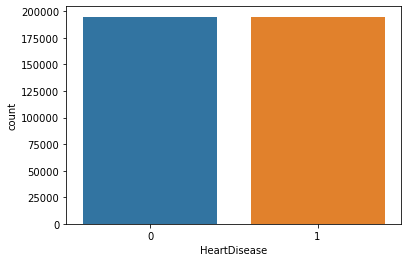

In [39]:
sns.countplot(x="HeartDisease", data=train_SMOTE)

In [40]:
# 저장
train_SMOTE.to_csv('train_SMOTE.csv', index=False)

### Modeling(Machine Learning)

In [91]:
train = pd.read_csv("train_SMOTE.csv",parse_dates=True, dayfirst=False)
val = pd.read_csv("val.csv",parse_dates=True, dayfirst=False)
test = pd.read_csv("test.csv",parse_dates=True, dayfirst=False)

In [92]:
train = train.iloc[:-1,:]
val = val.iloc[:-1,:]
test = test.iloc[:-1,:]

In [93]:
# data split
X_train= train.iloc[:,1:]
y_train= train.iloc[:,:1]
X_val= val.iloc[:,1:]
y_val= val.iloc[:,:1]
X_test= test.iloc[:,1:]
y_test= test.iloc[:,:1]

In [44]:
X_train = X_train.values
y_train = y_train.values.ravel()
X_val = X_val.values
y_val = y_val.values.ravel()
X_test = X_test.values
y_test = y_test.values.ravel()

In [45]:
# 평가 함수
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
#    f1 = f1_score(y_test, pred, average='micro')
    f1 = f1_score(y_test, pred, average='macro')
    cr = classification_report(y_test, pred)
    auc = roc_auc_score(y_test, pred)
    fpr, tpr, thres = roc_curve(y_test, pred)
    print('Confusion Matrix')
    print(confusion)
    print('Accuracy:{}, Precision:{}, recall:{}, F1-score:{}'.format(accuracy, precision, recall, f1))
    print(cr)
    print('AUC:{}'.format(auc))
    plot_roc_curve(fpr,tpr)
    plt.show

In [46]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr,tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('FPR')
    plt.ylabel('TPR')

#### Logistic Regression

In [47]:
%%time
from sklearn.linear_model import LogisticRegression

# 모델 생성 및 학습 시키기
logistic = LogisticRegression(max_iter=100, random_state=34)
logistic.fit(X_train, y_train)

CPU times: user 2.14 s, sys: 4.26 ms, total: 2.14 s
Wall time: 2.14 s


LogisticRegression(random_state=34)

In [48]:
# test 검증
y_log_pred_test = logistic.predict(X_test)

In [49]:
y_test.shape

(61879,)

In [50]:
y_log_pred_test.shape

(61879,)

Confusion Matrix
[[41776 14779]
 [ 1160  4164]]
Accuracy:0.7424166518528095, Precision:0.21981734677717363, recall:0.7821187077385424, F1-score:0.5914883267141406
              precision    recall  f1-score   support

           0       0.97      0.74      0.84     56555
           1       0.22      0.78      0.34      5324

    accuracy                           0.74     61879
   macro avg       0.60      0.76      0.59     61879
weighted avg       0.91      0.74      0.80     61879

AUC:0.7603989348081803


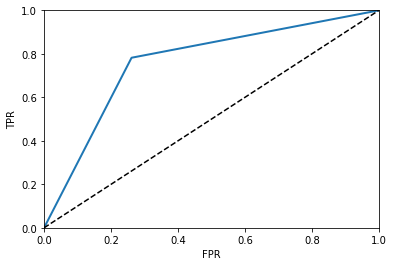

In [51]:
get_clf_eval(y_test, y_log_pred_test)

#### RandomForest Classifier

In [96]:
%%time
from sklearn.ensemble import RandomForestClassifier

#모델 훈련
rand_clf = RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=28, random_state=0)
rand_clf.fit(X_train, y_train)

y_pred_train = rand_clf.predict(X_train)

<timed exec>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


CPU times: user 10.2 s, sys: 17.4 ms, total: 10.2 s
Wall time: 10.6 s


In [97]:
importances = rand_clf.feature_importances_

In [98]:
print(importances)

[0.0153498  0.10642886 0.01707156 0.10601579 0.37590331 0.01908415
 0.0060966  0.01938244 0.05213541 0.01128666 0.00092251 0.0016662
 0.00439702 0.02646347 0.00079504 0.00139783 0.00297114 0.0004438
 0.00615694 0.00072139 0.03615497 0.00045327 0.02338247 0.01318706
 0.0200865  0.00885904 0.00459983 0.00110866 0.00101601 0.0010582
 0.00437947 0.0206311  0.02717133 0.06322215]


In [114]:
feature_scores = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)

In [119]:
feature_scores_top10 = feature_scores[:10]

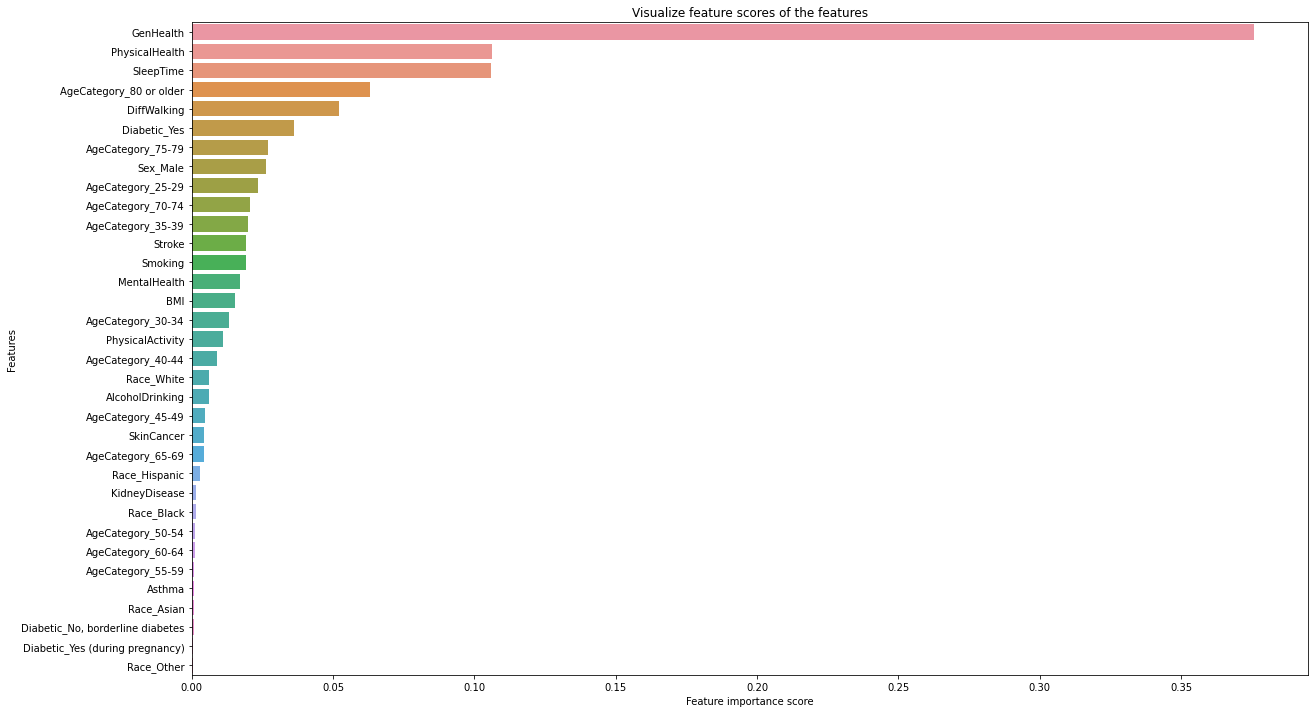

<Figure size 432x288 with 0 Axes>

In [122]:
# Creating a seaborn bar plot

f, ax = plt.subplots(figsize=(20, 12))
ax = sns.barplot(x=feature_scores, y=feature_scores.index, data=data)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()
plt.savefig('savefig_featureimportance.png')

Confusion Matrix
[[45083 11472]
 [ 1773  3551]]
Accuracy:0.7859532313062589, Precision:0.23637089795646676, recall:0.6669797145003756, F1-score:0.6104814666073548
              precision    recall  f1-score   support

           0       0.96      0.80      0.87     56555
           1       0.24      0.67      0.35      5324

    accuracy                           0.79     61879
   macro avg       0.60      0.73      0.61     61879
weighted avg       0.90      0.79      0.83     61879

AUC:0.7320664640930842


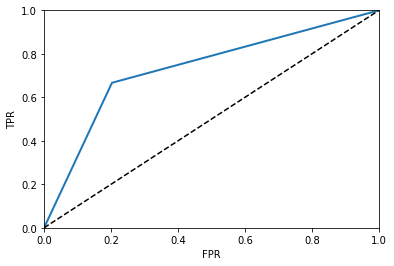

In [39]:
#test set으로 검증
y_randfore_pred_test = rand_clf.predict(X_test)
get_clf_eval(y_test, y_randfore_pred_test)

In [14]:
feature_scores = pd.Series(RandomForestClassifier.feature_importances_, index=X_train.columns)#.sort_values(ascending=False)

#### LightBGM

In [18]:
import re
X_train_lgb = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_val_lgb = X_val.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [20]:
lgb_train = lgb.Dataset(X_train_lgb, y_train)
lgb_val = lgb.Dataset(X_val_lgb, y_val, reference=lgb_train)

params={
    'num_leaves':50,
    'objective':'binary',
    'max_depth':9,
    'learning_rate':0.0001,
    'n_estimators':600
}
num_round=30000

model = lgb.train(params, lgb_train, valid_sets=[lgb_train, lgb_val], num_boost_round=num_round)

/home/yongk/anaconda3/envs/yongk_darts/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 193527, number of negative: 193528
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033581 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1333
[LightGBM] [Info] Number of data points in the train set: 387055, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499999 -> initscore=-0.000005
[LightGBM] [Info] Start training from score -0.000005
[1]	training's binary_logloss: 0.693099	valid_1's binary_logloss: 0.693101
[2]	training's binary_logloss: 0.69305	valid_1's binary_logloss: 0.693057
[3]	training's binary_logloss: 0.693001	valid_1's binary_logloss: 0.693013
[4]	training's binary_logloss: 0.692953	valid_1's binary_logloss: 0.692969
[5]	training's binary_logloss: 0.692904	valid_1's binary_logloss: 0.692925
[6]	training's binary_logloss: 0.692856	valid_1's binary_loglo

[118]	training's binary_logloss: 0.687477	valid_1's binary_logloss: 0.688007
[119]	training's binary_logloss: 0.68743	valid_1's binary_logloss: 0.687964
[120]	training's binary_logloss: 0.687382	valid_1's binary_logloss: 0.687921
[121]	training's binary_logloss: 0.687335	valid_1's binary_logloss: 0.687878
[122]	training's binary_logloss: 0.687288	valid_1's binary_logloss: 0.687835
[123]	training's binary_logloss: 0.68724	valid_1's binary_logloss: 0.687792
[124]	training's binary_logloss: 0.687193	valid_1's binary_logloss: 0.687749
[125]	training's binary_logloss: 0.687145	valid_1's binary_logloss: 0.687706
[126]	training's binary_logloss: 0.687098	valid_1's binary_logloss: 0.687663
[127]	training's binary_logloss: 0.68705	valid_1's binary_logloss: 0.68762
[128]	training's binary_logloss: 0.687003	valid_1's binary_logloss: 0.687577
[129]	training's binary_logloss: 0.686956	valid_1's binary_logloss: 0.687534
[130]	training's binary_logloss: 0.686908	valid_1's binary_logloss: 0.687491
[13

[226]	training's binary_logloss: 0.682403	valid_1's binary_logloss: 0.683406
[227]	training's binary_logloss: 0.682357	valid_1's binary_logloss: 0.683364
[228]	training's binary_logloss: 0.68231	valid_1's binary_logloss: 0.683322
[229]	training's binary_logloss: 0.682264	valid_1's binary_logloss: 0.68328
[230]	training's binary_logloss: 0.682217	valid_1's binary_logloss: 0.683238
[231]	training's binary_logloss: 0.682171	valid_1's binary_logloss: 0.683196
[232]	training's binary_logloss: 0.682124	valid_1's binary_logloss: 0.683154
[233]	training's binary_logloss: 0.682078	valid_1's binary_logloss: 0.683111
[234]	training's binary_logloss: 0.682031	valid_1's binary_logloss: 0.683069
[235]	training's binary_logloss: 0.681985	valid_1's binary_logloss: 0.683027
[236]	training's binary_logloss: 0.681939	valid_1's binary_logloss: 0.682985
[237]	training's binary_logloss: 0.681892	valid_1's binary_logloss: 0.682943
[238]	training's binary_logloss: 0.681846	valid_1's binary_logloss: 0.682901
[

[336]	training's binary_logloss: 0.677344	valid_1's binary_logloss: 0.678817
[337]	training's binary_logloss: 0.677299	valid_1's binary_logloss: 0.678775
[338]	training's binary_logloss: 0.677253	valid_1's binary_logloss: 0.678734
[339]	training's binary_logloss: 0.677208	valid_1's binary_logloss: 0.678693
[340]	training's binary_logloss: 0.677162	valid_1's binary_logloss: 0.678651
[341]	training's binary_logloss: 0.677117	valid_1's binary_logloss: 0.67861
[342]	training's binary_logloss: 0.677072	valid_1's binary_logloss: 0.678569
[343]	training's binary_logloss: 0.677026	valid_1's binary_logloss: 0.678528
[344]	training's binary_logloss: 0.676981	valid_1's binary_logloss: 0.678486
[345]	training's binary_logloss: 0.676935	valid_1's binary_logloss: 0.678445
[346]	training's binary_logloss: 0.67689	valid_1's binary_logloss: 0.678404
[347]	training's binary_logloss: 0.676844	valid_1's binary_logloss: 0.678363
[348]	training's binary_logloss: 0.676799	valid_1's binary_logloss: 0.678322
[

[446]	training's binary_logloss: 0.672393	valid_1's binary_logloss: 0.674321
[447]	training's binary_logloss: 0.672349	valid_1's binary_logloss: 0.674281
[448]	training's binary_logloss: 0.672304	valid_1's binary_logloss: 0.67424
[449]	training's binary_logloss: 0.67226	valid_1's binary_logloss: 0.6742
[450]	training's binary_logloss: 0.672215	valid_1's binary_logloss: 0.67416
[451]	training's binary_logloss: 0.672171	valid_1's binary_logloss: 0.674119
[452]	training's binary_logloss: 0.672126	valid_1's binary_logloss: 0.674079
[453]	training's binary_logloss: 0.672082	valid_1's binary_logloss: 0.674038
[454]	training's binary_logloss: 0.672037	valid_1's binary_logloss: 0.673998
[455]	training's binary_logloss: 0.671993	valid_1's binary_logloss: 0.673958
[456]	training's binary_logloss: 0.671948	valid_1's binary_logloss: 0.673917
[457]	training's binary_logloss: 0.671904	valid_1's binary_logloss: 0.673877
[458]	training's binary_logloss: 0.671859	valid_1's binary_logloss: 0.673837
[459

[555]	training's binary_logloss: 0.66759	valid_1's binary_logloss: 0.669958
[556]	training's binary_logloss: 0.667546	valid_1's binary_logloss: 0.669918
[557]	training's binary_logloss: 0.667502	valid_1's binary_logloss: 0.669879
[558]	training's binary_logloss: 0.667459	valid_1's binary_logloss: 0.669839
[559]	training's binary_logloss: 0.667415	valid_1's binary_logloss: 0.669799
[560]	training's binary_logloss: 0.667372	valid_1's binary_logloss: 0.66976
[561]	training's binary_logloss: 0.667328	valid_1's binary_logloss: 0.66972
[562]	training's binary_logloss: 0.667285	valid_1's binary_logloss: 0.669681
[563]	training's binary_logloss: 0.667241	valid_1's binary_logloss: 0.669641
[564]	training's binary_logloss: 0.667198	valid_1's binary_logloss: 0.669601
[565]	training's binary_logloss: 0.667154	valid_1's binary_logloss: 0.669562
[566]	training's binary_logloss: 0.667111	valid_1's binary_logloss: 0.669522
[567]	training's binary_logloss: 0.667067	valid_1's binary_logloss: 0.669483
[5

Confusion Matrix
[[47108  9447]
 [ 2610  2714]]
Accuracy:0.8051519901743726, Precision:0.22317243647726337, recall:0.5097670924117205, F1-score:0.5984922150351462
              precision    recall  f1-score   support

           0       0.95      0.83      0.89     56555
           1       0.22      0.51      0.31      5324

    accuracy                           0.81     61879
   macro avg       0.59      0.67      0.60     61879
weighted avg       0.89      0.81      0.84     61879

AUC:0.6713630794036324


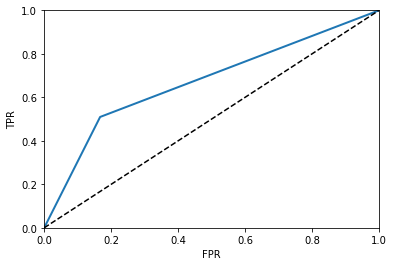

In [21]:
y_lgb_pred_test = model.predict(X_test)
y_lgb_pred_test = (y_lgb_pred_test > 0.5).astype(int)
get_clf_eval(y_test, y_lgb_pred_test)

#### KNN

In [22]:
%%time
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

CPU times: user 52 ms, sys: 52 ms, total: 104 ms
Wall time: 102 ms


/home/yongk/anaconda3/envs/yongk_darts/lib/python3.7/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier()

Confusion Matrix
[[45003 11552]
 [ 2433  2891]]
Accuracy:0.7739944084422825, Precision:0.20016617046320018, recall:0.5430127723516154, F1-score:0.5790124615491373
              precision    recall  f1-score   support

           0       0.95      0.80      0.87     56555
           1       0.20      0.54      0.29      5324

    accuracy                           0.77     61879
   macro avg       0.57      0.67      0.58     61879
weighted avg       0.88      0.77      0.82     61879

AUC:0.6693757169157953


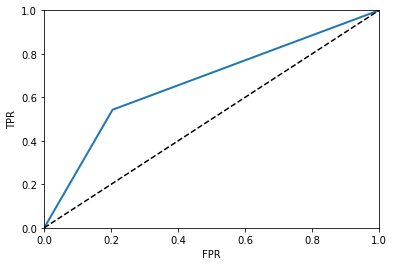

In [23]:
y_knn_pred_test = knn.predict(X_test)
get_clf_eval(y_test, y_knn_pred_test)

### SVC

In [26]:
%%time
svc=SVC()
svc.fit(X_train, y_train)

/home/yongk/anaconda3/envs/yongk_darts/lib/python3.7/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 3h 33min 25s, sys: 15 s, total: 3h 33min 40s
Wall time: 3h 33min 42s


SVC()

In [27]:
y_svc_pred = svc.predict(X_test)

Confusion Matrix
[[41101 15454]
 [ 1249  4075]]
Accuracy:0.7300699752743257, Precision:0.2086640380971888, recall:0.7654019534184824, F1-score:0.5795244951898988
              precision    recall  f1-score   support

           0       0.97      0.73      0.83     56555
           1       0.21      0.77      0.33      5324

    accuracy                           0.73     61879
   macro avg       0.59      0.75      0.58     61879
weighted avg       0.90      0.73      0.79     61879

AUC:0.7460729155298583


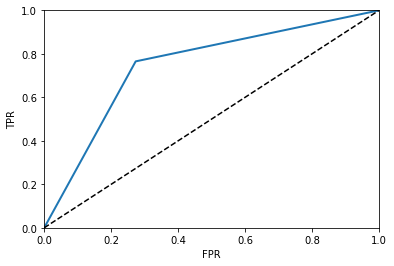

In [28]:
get_clf_eval(y_test, y_svc_pred)

### DNN

In [38]:
USE_CUDA = torch.cuda.is_available()
torch.cuda.is_available()

True

In [39]:
device = torch.device("cuda" if USE_CUDA else "cpu")
print(device)

cuda


In [86]:
y_test.shape

(61880,)

In [278]:
"""
torch Variable에는 3개의 형태가 있다. 
data, grad, grad_fn 한 번 구글에 찾아서 공부해보길 바랍니다. 
"""
X_train_SMOTE_DNN = torch.Tensor(X_train_SMOTE.values)
X_test_DNN = torch.Tensor(X_test.values)

y_train_SMOTE_DNN = torch.Tensor(y_train_SMOTE.values)
y_test_DNN = torch.Tensor(y_test.values)

In [279]:
X_train_SMOTE_DNN_final = torch.reshape(X_train_SMOTE_DNN,   (X_train_SMOTE_DNN.shape[0], 1, X_train_SMOTE_DNN.shape[1]))
X_test_DNN_final = torch.reshape(X_test_DNN,  (X_test_DNN.shape[0], 1, X_test_DNN.shape[1]))

In [275]:
y_train_SMOTE_DNN = torch.reshape(y_train_SMOTE_DNN,  (y_train_SMOTE_DNN.shape[0],))

In [280]:
print("Training Shape", X_train_SMOTE_DNN_final.shape, y_train_SMOTE_DNN.shape)
print("Testing Shape", X_test_DNN_final.shape, y_test_DNN.shape) 

Training Shape torch.Size([389746, 1, 23]) torch.Size([389746, 1])
Testing Shape torch.Size([61880, 1, 23]) torch.Size([61880])


In [281]:
train_data_DNN = torch.utils.data.TensorDataset(X_train_SMOTE_DNN_final, y_train_SMOTE_DNN)
test_data_DNN = torch.utils.data.TensorDataset(X_test_DNN_final, y_test_DNN)

In [291]:
train_loader = DataLoader(dataset=train_data_DNN, batch_size=1024, shuffle=True, num_workers=12, persistent_workers=True)
test_loader = DataLoader(dataset=test_data_DNN, batch_size=1024, shuffle=True, num_workers=12, persistent_workers=True)

In [201]:
# Set Hyper parameters and other variables to train the model.
epochs = 50
#lr = 0.01
momentum = 0.5
log_interval = 200

In [202]:
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.003)

In [292]:
# 모델 정의
class Net(nn.Module): # 신경망 모듈 상속받는 파이썬 클래스 정의
    def __init__(self, input_size, hidden_size): # 객체 생성 시 자동 호출 되는 init 함수
        super(Net, self).__init__() # Net 클래스가 nn.Module의 속성을 갖고 초기화
        self.input_size = input_size # 입력 데이터의 차원
        self.hidden_size = hidden_size # linear layer 내 은닉 유닛 개수
        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU() # activation function ReLU 선언
        self.fc2 = nn.Linear(self.hidden_size, 8)
        self.fc3 = nn.Linear(8, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        linear1 = self.fc1(x)
        #relu1 = self.relu(linear1)
        linear2 = self.fc2(linear1)
        #relu2 = self.relu(linear2)
        linear3 = self.fc3(linear2)
        
        #output = linear3
        output = self.sigmoid(linear3)
        #x = F.relu(self.fc1(x.view(-1,23)))
        
        return output

print("init model done")
net = Net(input_size = 23, hidden_size = 16).to(device)
net.to(device)
print(net)

init model done
Net(
  (fc1): Linear(in_features=23, out_features=16, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [289]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [293]:
%%time

for e in range(100):
    epoch_loss = 0
    epoch_acc = 0
    net.train()
    for i, (X, y_batch) in enumerate(train_loader):
        X, y_batch = X.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        y_pred = net(X)

        loss = criterion(y_pred, y_batch.unsqueeze(-1))
        #loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(-1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        #print(X.shape, y_batch.shape, y_pred.shape)
    if (e%10 == 0):
      print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')
      print(X.shape, y_batch.shape, y_pred.shape)

Epoch 000: | Loss: 0.74012 | Acc: 49.995
torch.Size([626, 1, 23]) torch.Size([626, 1]) torch.Size([626, 1, 1])
Epoch 010: | Loss: 0.74009 | Acc: 50.000
torch.Size([626, 1, 23]) torch.Size([626, 1]) torch.Size([626, 1, 1])
Epoch 020: | Loss: 0.74013 | Acc: 49.992
torch.Size([626, 1, 23]) torch.Size([626, 1]) torch.Size([626, 1, 1])


KeyboardInterrupt: 

In [187]:
y_pred_list = []
net.eval()
with torch.no_grad():
    for i, (X_batch, y) in enumerate(test_loader):
        X_batch = torch.FloatTensor(X_batch)
        X_batch = X_batch.to(device)
        y_test_pred = net(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [188]:
y_pred_list

[[1.0,
  1.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  1.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  0.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  1.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,

#Define Train function and Test function to validate.

def train(log_interval, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(log_interval, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    witmh torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() 
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format
          (test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [183]:
print(classification_report(y_test, y_pred_list))

ValueError: Found input variables with inconsistent numbers of samples: [61880, 61]

In [ ]:
## test data    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data_DNN = testData(torch.FloatTensor(X_test_DNN))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/yongk/anaconda3/envs/yongk_darts/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_119074/782050811.py", line 31, in <module>
    test_data_DNN = testData(torch.FloatTensor(X_test_DNN))
NameError: name 'X_test_DNN' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/yongk/anaconda3/envs/yongk_darts/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2077, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/yongk/anaconda3/envs/yongk_darts/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getin

In [33]:
from torch.utils.data import Dataset
## train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data_DNN = trainData(torch.FloatTensor(X_train_SMOTE_DNN), 
                       torch.FloatTensor(y_train_SMOTE_DNN))

In [ ]:
min_valid_loss = np.inf

for e in range(epochs):
    train_loss = 0.0
    model.train()     # Optional when not using Model Specific layer
    for data, labels in trainloader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
        
        optimizer.zero_grad()
        y_pred = net(X)
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    y_pred_list = []
    model.eval()     # Optional when not using Model Specific layer
    with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
    
    for data, labels in validloader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
        
        target = model(data)
        loss = criterion(target,labels)
        valid_loss = loss.item() * data.size(0)

    print(f'Epoch {e+1} \t\t Training Loss: {train_loss / len(trainloader)} \t\t Validation Loss: {valid_loss / len(validloader)}')
    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss
        # Saving State Dict
        torch.save(model.state_dict(), 'saved_model.pth')

In [ ]:
for epoch in range (50):

    for i, (X, y_batch) in enumerate(trainLoder):

        trainn = Variable(images.view(-1,28*28))
        labels = Variable(labels.

        optimizer.zero_grad()

        output = model(trainn)

        loss = error(output,labels)

        loss.backward()

        optimizer.step()

        count+=1



        if (count%50==0):

            correct=0
            total = 0

            for image,label in testLoder:

                testt = Variable(image.view(-1,28*28))

                outputs = model(testt)

                predicted = torch.max(outputs.data,1)[1]

                total+=len(label)

                correct += (predicted == label).sum()

            accuracy = 100*correct/float(total)

            lossList.append(loss.data)
            iterationList.append(count)

        if (count%500==0):

            print("Epoch: {} Iteration: {} Loss: {} Accuracy: {}%".format(epoch,count,loss.data,accuracy))